# AI 제작 여부와 메시지 유무가 대학생의 지각된 가치에 미치는 영향

## 연구 분석 보고서

**연구 설계**: 2(제작 주체: AI vs 인간 전문가) × 2(영상 서사성: 서사 vs 비서사) 피험자 간 설계

**분석 방법**: Two-way ANCOVA (공변량: 장르선호도)

---

## 0. 패키지 및 환경 설정

In [14]:
# 필요한 패키지 설치 (필요시 주석 해제)
!pip install pandas numpy scipy statsmodels pingouin matplotlib seaborn openpyxl

In [38]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import OLSInfluence
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
# Mac의 경우: plt.rcParams['font.family'] = 'AppleGothic'
# Linux의 경우: plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("패키지 로드 완료!")

패키지 로드 완료!


## 1. 데이터 로드 및 전처리

In [ ]:
# ============================================================================
# 1. 데이터 로드 및 전처리
# ============================================================================

import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# 파일 경로 설정
files = {
    'AI_서사': 'AI 서사.xlsx',
    'AI_비서사': 'AI 비서사.xlsx',
    '인간_서사': '인간 서사.xlsx',
    '인간_비서사': '인간 비서사.xlsx'
}

# 각 파일 로드 및 그룹 정보 추가
dataframes = []

for group_name, file_path in files.items():
    df = pd.read_excel(file_path)
    
    # 그룹 정보 추가
    if 'AI' in group_name:
        df['제작주체'] = 'AI'
    else:
        df['제작주체'] = '인간'
    
    # 비서사를 먼저 체크 (비서사에도 '서사'가 포함되어 있으므로)
    if '비서사' in group_name:
        df['서사성'] = '비서사'
    else:
        df['서사성'] = '서사'
    
    df['그룹'] = group_name
    dataframes.append(df)

# 데이터 통합
df_all = pd.concat(dataframes, ignore_index=True)

print(f"통합 전 데이터: {len(df_all)}명")

# ============================================================================
# 나이 데이터 전처리
# ============================================================================

# 나이 컬럼명 (실제 컬럼명으로 변경)
age_col = '귀하의 나이를 숫자로 기입해 주십시오(만 연령 기준). '

# 나이 데이터를 숫자로 변환하는 함수
def clean_age(age_value):
    """
    나이 데이터를 숫자로 변환
    - '25세' -> 25
    - '만 21' -> 21
    - '25' -> 25
    - 25 -> 25
    """
    if pd.isna(age_value):
        return np.nan
    
    # 문자열로 변환
    age_str = str(age_value).strip()
    
    # 숫자만 추출 (정규표현식 사용)
    numbers = re.findall(r'\d+', age_str)
    if numbers:
        return int(numbers[0])
    
    return np.nan

# 나이 전처리 적용
df_all['나이'] = df_all[age_col].apply(clean_age)

print(f"\n나이 변환 전: {df_all[age_col].unique()[:10]}")
print(f"나이 변환 후: {sorted(df_all['나이'].dropna().unique())}")

# ============================================================================
# 19~29세 데이터만 필터링
# ============================================================================

df_filtered = df_all[(df_all['나이'] >= 19) & (df_all['나이'] <= 29)].copy()

print(f"\n19~29세 필터링 후: {len(df_filtered)}명")
print(f"제거된 응답자: {len(df_all) - len(df_filtered)}명")

# 연령대 분포 확인
print(f"\n최종 데이터 연령 분포:")
print(df_filtered['나이'].value_counts().sort_index())

# 그룹별 샘플 수 확인
print(f"\n그룹별 샘플 수:")
print(df_filtered.groupby(['제작주체', '서사성']).size())

# ============================================================================
# 최종 데이터 저장
# ============================================================================

# 전처리된 데이터 저장
df_filtered.to_csv('data_prep.csv', index=False, encoding='utf-8-sig')

print(f"\n전처리 완료! 최종 데이터: {len(df_filtered)}명")
print(f"저장 위치: data_prep.csv")

통합 전 데이터: 117명

나이 변환 전: [21 20 23 19 22 '21세' 56 26 52 24]
나이 변환 후: [np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(52), np.int64(56)]

19~29세 필터링 후: 109명
제거된 응답자: 8명

최종 데이터 연령 분포:
나이
19    14
20    32
21    20
22    15
23    15
24     3
25     2
26     8
Name: count, dtype: int64

그룹별 샘플 수:
제작주체  서사성
AI    비서사    31
      서사     30
인간    비서사    24
      서사     24
dtype: int64

전처리 완료! 최종 데이터: 109명
저장 위치: data_preprocessed.csv


In [54]:
# 데이터 통합

df = pd.read_csv('data_preprocessed.csv')

df = pd.DataFrame(df)
print(f"총 응답자 수: {len(df)}명")
print(f"\n집단별 응답자 수:")
print(df.groupby(['제작주체', '서사성']).size())

총 응답자 수: 109명

집단별 응답자 수:
제작주체  서사성
AI    비서사    31
      서사     30
인간    비서사    24
      서사     24
dtype: int64


In [55]:
import pandas as pd

# 문제가 발생한 '신뢰성' 관련 컬럼 리스트
cols_to_fix = ['신뢰성1', '신뢰성2', '신뢰성3', '신뢰성4']

# 1. 해당 컬럼들을 숫자로 강제 변환 (에러가 나는 값은 NaN으로 처리됨)
df[cols_to_fix] = df[cols_to_fix].apply(pd.to_numeric, errors='coerce')

# 2. (선택사항) NaN(결측치)이 생겼다면 0이나 평균으로 채우기 (필요 시)
# df[cols_to_fix] = df[cols_to_fix].fillna(0)

# 원래 코드 실행
df['신뢰성'] = df[cols_to_fix].mean(axis=1)

In [ ]:
# 하위 척도 및 전체 지각된 가치 평균 계산
df['효용성'] = df[['효용성1', '효용성2', '효용성3']].mean(axis=1)
df['감정공감'] = df[['감정공감1', '감정공감2', '감정공감3']].mean(axis=1)
df['신뢰성'] = df[['신뢰성1', '신뢰성2', '신뢰성3', '신뢰성4']].mean(axis=1)
df['몰입감'] = df[['몰입감1', '몰입감2', '몰입감3']].mean(axis=1)

# 전체 지각된 가치 (13개 문항 평균)
value_items = ['효용성1', '효용성2', '효용성3', '감정공감1', '감정공감2', '감정공감3',
               '신뢰성1', '신뢰성2', '신뢰성3', '신뢰성4', '몰입감1', '몰입감2', '몰입감3']
df['지각된가치'] = df[value_items].mean(axis=1)                         ## '지각된 가치'는 13가지 응답의 산술평균

print("변수 생성 완료!")
df[['제작주체', '서사성', '효용성', '감정공감', '신뢰성', '몰입감', '지각된가치', '장르선호']].head()

변수 생성 완료!


,제작주체,서사성,효용성,감정공감,신뢰성,몰입감,지각된가치,장르선호
0,AI,서사,3.666667,4.000000,4.00,2.333333,3.538462,5
1,AI,서사,5.666667,5.333333,3.25,6.000000,4.923077,5
2,AI,서사,2.666667,3.000000,4.50,2.666667,3.307692,1
3,AI,서사,4.333333,5.000000,4.25,4.000000,4.384615,5
4,AI,서사,5.000000,4.333333,2.75,4.333333,4.000000,4


---
## 2. 1단계: 기술통계 및 신뢰도 분석

### 2.1 신뢰도 분석 (Cronbach's Alpha)

In [88]:
def cronbach_alpha(items_df):
    """Cronbach's Alpha 계산 함수"""
    items_df = items_df.dropna()
    n_items = items_df.shape[1]
    if n_items < 2:
        return np.nan
    item_variances = items_df.var(axis=0, ddof=1)
    total_var = items_df.sum(axis=1).var(ddof=1)
    return (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_var)

# 각 척도별 신뢰도 계산
reliability_results = {
    '효용성 (3문항)': cronbach_alpha(df[['효용성1', '효용성2', '효용성3']]),
    '감정적 공감 (3문항)': cronbach_alpha(df[['감정공감1', '감정공감2', '감정공감3']]),
    '신뢰성 (4문항)': cronbach_alpha(df[['신뢰성1', '신뢰성2', '신뢰성3', '신뢰성4']]),
    '몰입감 (3문항)': cronbach_alpha(df[['몰입감1', '몰입감2', '몰입감3']]),
}

print("=" * 50)
print("신뢰도 분석 결과 (Cronbach's Alpha)")
print("=" * 50)
for scale, alpha in reliability_results.items():
    print(f"{scale}: α = {alpha:.3f}")

신뢰도 분석 결과 (Cronbach's Alpha)
효용성 (3문항): α = 0.895
감정적 공감 (3문항): α = 0.933
신뢰성 (4문항): α = 0.867
몰입감 (3문항): α = 0.894


### 2.2 기술통계

In [90]:
# 집단별 기술통계
desc_stats = df.groupby(['서사성', '제작주체']).agg({
    '지각된가치': ['count', 'mean', 'std'],
    '효용성': ['mean', 'std'],
    '감정공감': ['mean', 'std'],
    '신뢰성': ['mean', 'std'],
    '몰입감': ['mean', 'std']
}).round(3)

print("=" * 70)
print("집단별 기술통계")
print("=" * 70)
desc_stats

집단별 기술통계


지각된가치                  효용성          감정공감           신뢰성           몰입감  \
         count   mean    std   mean    std   mean    std   mean    std   mean   
서사성 제작주체                                                                        
비서사 AI      31  4.007  1.343  3.710  1.650  3.914  1.601  4.081  1.382  4.301   
    인간      24  4.170  1.316  3.819  1.387  3.333  1.507  5.198  1.588  3.986   
서사  AI      30  3.731  1.289  3.911  1.506  3.856  1.594  3.675  1.338  3.500   
    인간      24  4.795  1.320  4.444  1.553  5.069  1.642  4.958  1.308  4.653   

                 
            std  
서사성 제작주체         
비서사 AI    1.595  
    인간    1.646  
서사  AI    1.672  
    인간    1.718

---
## 3. ANCOVA 가정 검증

### 3.1 정규성 검정 (Shapiro-Wilk Test)

In [61]:
print("=" * 60)
print("정규성 검정 (Shapiro-Wilk Test)")
print("=" * 60)

groups = [('AI', '서사'), ('AI', '비서사'), ('인간', '서사'), ('인간', '비서사')]

normality_results = []
for producer, narrative in groups:
    subset = df[(df['제작주체'] == producer) & (df['서사성'] == narrative)]['지각된가치']
    stat, p = stats.shapiro(subset)
    result = "정규분포 가정 충족" if p > 0.05 else "정규분포 가정 위배"
    normality_results.append({'집단': f"{producer}/{narrative}", 'W': stat, 'p': p, '결과': result})
    print(f"{producer}/{narrative}: W = {stat:.3f}, p = {p:.4f} → {result}")

normality_df = pd.DataFrame(normality_results)
print("\n→ 모든 집단에서 정규분포 가정 충족")

정규성 검정 (Shapiro-Wilk Test)
AI/서사: W = 0.957, p = 0.2527 → 정규분포 가정 충족
AI/비서사: W = 0.938, p = 0.0729 → 정규분포 가정 충족
인간/서사: W = 0.936, p = 0.1325 → 정규분포 가정 충족
인간/비서사: W = 0.943, p = 0.1903 → 정규분포 가정 충족

→ 모든 집단에서 정규분포 가정 충족


### 3.2 등분산 검정 (Levene's Test)

In [91]:
print("=" * 60)
print("등분산 검정 (Levene's Test)")
print("=" * 60)

# 4개 집단 데이터 분리
ai_nar = df[(df['제작주체'] == 'AI') & (df['서사성'] == '서사')]['지각된가치']
ai_non = df[(df['제작주체'] == 'AI') & (df['서사성'] == '비서사')]['지각된가치']
hu_nar = df[(df['제작주체'] == '인간') & (df['서사성'] == '서사')]['지각된가치']
hu_non = df[(df['제작주체'] == '인간') & (df['서사성'] == '비서사')]['지각된가치']

# 지각된 가치
stat, p = stats.levene(ai_nar, ai_non, hu_nar, hu_non)
result = "등분산 가정 충족" if p > 0.05 else "등분산 가정 위배"

# 하위 척도별
for var in ['효용성', '감정공감', '신뢰성', '몰입감']:
    g1 = df[(df['제작주체'] == 'AI') & (df['서사성'] == '서사')][var]
    g2 = df[(df['제작주체'] == 'AI') & (df['서사성'] == '비서사')][var]
    g3 = df[(df['제작주체'] == '인간') & (df['서사성'] == '서사')][var]
    g4 = df[(df['제작주체'] == '인간') & (df['서사성'] == '비서사')][var]
    stat, p = stats.levene(g1, g2, g3, g4)
    result = "충족" if p > 0.05 else "위배"
    print(f"{var}: F = {stat:.3f}, p = {p:.4f} → {result}")

print("\n→ 모든 변수에서 등분산 가정 충족")

등분산 검정 (Levene's Test)
효용성: F = 0.414, p = 0.7433 → 충족
감정공감: F = 0.122, p = 0.9470 → 충족
신뢰성: F = 0.489, p = 0.6904 → 충족
몰입감: F = 0.166, p = 0.9191 → 충족

→ 모든 변수에서 등분산 가정 충족


### 3.3 기울기 동질성 검정

In [92]:
print("=" * 60)
print("기울기 동질성 검정")
print("=" * 60)

# 공변량 × 독립변수 상호작용 검정
model_homogeneity = ols('지각된가치 ~ C(제작주체) * C(서사성) * 장르선호', data=df).fit()
anova_homo = sm.stats.anova_lm(model_homogeneity, typ=2)

# 3원 상호작용 확인
interaction_f = anova_homo.loc['C(제작주체):C(서사성):장르선호', 'F']
interaction_p = anova_homo.loc['C(제작주체):C(서사성):장르선호', 'PR(>F)']
result = "충족 (p > .05)" if interaction_p > 0.05 else "위배 (p < .05)"

print(f"공변량 × 제작주체 × 서사성 상호작용:")
print(f"F = {interaction_f:.3f}, p = {interaction_p:.4f}")
print(f"\n→ 기울기 동질성 가정: {result}")

기울기 동질성 검정
공변량 × 제작주체 × 서사성 상호작용:
F = 0.421, p = 0.5179

→ 기울기 동질성 가정: 충족 (p > .05)


---
## 4. 이원공분산분석 (Two-way ANCOVA)

### 4.1 지각된 가치에 대한 ANCOVA

In [95]:
print("=" * 70)
print("Two-way ANCOVA: 지각된 가치")
print("=" * 70)

# ANCOVA 모형
model = ols('지각된가치 ~ 장르선호 + C(제작주체) * C(서사성)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# 효과크기 계산 (partial eta squared)
anova_table['partial η²'] = anova_table['sum_sq'] / (anova_table['sum_sq'] + anova_table.loc['Residual', 'sum_sq'])

print(anova_table.round(4))
print("\n[효과크기 해석 기준]")
print("partial η² < .01: 작은 효과 / .01-.06: 중간 효과 / > .14: 큰 효과")

Two-way ANCOVA: 지각된 가치
                  sum_sq     df        F  PR(>F)  partial η²
C(제작주체)           9.7175    1.0   6.8156  0.0104      0.0615
C(서사성)            0.5799    1.0   0.4067  0.5250      0.0039
C(제작주체):C(서사성)    5.1646    1.0   3.6223  0.0598      0.0337
장르선호             33.9651    1.0  23.8223  0.0000      0.1864
Residual        148.2804  104.0      NaN     NaN      0.5000

[효과크기 해석 기준]
partial η² < .01: 작은 효과 / .01-.06: 중간 효과 / > .14: 큰 효과


## 분석 결과

| 변인 | SS | df | F | p | partial η² | 해석 |
|:-----|-------:|---:|-------:|-------:|----------:|:-----|
| **제작주체** | 9.72 | 1 | 6.82 | **.010*** | .062 | 중간 효과 |
| **서사성** | 0.58 | 1 | 0.41 | .525 | .004 | 작은 효과 |
| **제작주체 × 서사성** | 5.16 | 1 | 3.62 | **.060†** | .034 | 중간 효과 |
| 장르선호 (공변량) | 33.97 | 1 | 23.82 | **< .001*** | .186 | 큰 효과 |
| 잔차 | 148.28 | 104 | — | — | — | — |

## 주요 결과 요약

- **제작주체 주효과**: 유의함 (p = .010)
  - AI 제작물이 인간 제작물보다 낮은 가치 평가
  
- **서사성 주효과**: 비유의 (p = .525)
  - 서사 vs 비서사 단독으로는 차이 없음
  
- **상호작용 효과**: 경계선 유의 (p = .060)
  - 제작주체의 효과가 서사성에 따라 다르게 나타남
  
- **공변량 (장르선호)**: 강한 영향 (p < .001, partial η² = .186)
  - 적절한 통제 변수로 작용

### 4.2 하위 척도별 ANCOVA

In [96]:
# 하위 척도별 ANCOVA 분석
subscale_results = []

for var in ['효용성', '감정공감', '신뢰성', '몰입감']:
    model = ols(f'{var} ~ 장르선호 + C(제작주체) * C(서사성)', data=df).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    
    subscale_results.append({
        '척도': var,
        '제작주체_F': anova.loc['C(제작주체)', 'F'],
        '제작주체_p': anova.loc['C(제작주체)', 'PR(>F)'],
        '서사성_F': anova.loc['C(서사성)', 'F'],
        '서사성_p': anova.loc['C(서사성)', 'PR(>F)'],
        '상호작용_F': anova.loc['C(제작주체):C(서사성)', 'F'],
        '상호작용_p': anova.loc['C(제작주체):C(서사성)', 'PR(>F)']
    })

subscale_df = pd.DataFrame(subscale_results)

# p-value에 유의수준 표시 추가
def format_p(p):
    if p < .001: return f"{p:.3f}***"
    elif p < .01: return f"{p:.3f}**"
    elif p < .05: return f"{p:.3f}*"
    elif p < .10: return f"{p:.3f}†"
    else: return f"{p:.3f}"

# F값과 p값 포맷팅
for col in ['제작주체', '서사성', '상호작용']:
    subscale_df[f'{col}_F'] = subscale_df[f'{col}_F'].round(3)
    subscale_df[f'{col}_p'] = subscale_df[f'{col}_p'].apply(format_p)

print("=" * 80)
print("하위 척도별 Two-way ANCOVA 결과 요약")
print("=" * 80)
print(subscale_df.to_string(index=False))
print("\nNote. †p < .10, *p < .05, **p < .01, ***p < .001")

하위 척도별 Two-way ANCOVA 결과 요약
  척도  제작주체_F   제작주체_p  서사성_F   서사성_p  상호작용_F  상호작용_p
 효용성   1.402    0.239  2.637   0.107   0.563   0.455
감정공감   1.095    0.298  6.986 0.009**   9.422 0.003**
 신뢰성  20.393 0.000***  1.465   0.229   0.083   0.774
 몰입감   1.968    0.164  0.182   0.671   6.259  0.014*

Note. †p < .10, *p < .05, **p < .01, ***p < .001


## 하위 척도별 요약

| 척도 | 제작주체 | 서사성 | 상호작용 | 해석 |
|:-----|:--------:|:------:|:--------:|:-----|
| 효용성 | NS | NS | NS | 차이 없음 |
| 감정공감 | NS | ** | *** | 서사적 콘텐츠에서 인간 우위 |
| 신뢰성 | *** | NS | NS | 일관되게 인간 우위 |
| 몰입감 | NS | NS | * | 서사적 콘텐츠에서 인간 우위 |

**Note.** NS = not significant; *p < .05, **p < .01, ***p < .001

---
## 5. 사후 분석

### 5.1 단순 주효과 분석 (독립표본 T-검정)

In [ ]:
def simple_effect_analysis(df, dv, condition_var, condition_val, group_var):
    """조건별 독립표본 t검정 + Cohen's d"""
    subset = df[df[condition_var] == condition_val]
    g1 = subset[subset[group_var] == 'AI'][dv]
    g2 = subset[subset[group_var] == '인간'][dv]
    
    t, p = stats.ttest_ind(g1, g2)
    
    # Cohen's d
    n1, n2 = len(g1), len(g2)
    pooled_std = np.sqrt(((n1-1)*g1.std()**2 + (n2-1)*g2.std()**2) / (n1+n2-2))
    d = (g1.mean() - g2.mean()) / pooled_std
    
    return {
        'AI_M': g1.mean(), 'AI_SD': g1.std(), 'AI_n': n1,
        '인간_M': g2.mean(), '인간_SD': g2.std(), '인간_n': n2,
        't': t, 'df': n1 + n2 - 2, 'p': p, 'Cohen_d': d
    }

In [98]:
print("=" * 70)
print("단순 주효과 분석: 지각된 가치")
print("=" * 70)

# H1 검증: 서사적 영상에서 AI vs 인간
print("\n▶ H1 검증: 서사적 영상에서 AI vs 인간")
print("-" * 50)
result = simple_effect_analysis(df, '지각된가치', '서사성', '서사', '제작주체')
print(f"AI:    M = {result['AI_M']:.2f}, SD = {result['AI_SD']:.2f}, n = {result['AI_n']}")
print(f"인간:  M = {result['인간_M']:.2f}, SD = {result['인간_SD']:.2f}, n = {result['인간_n']}")
print(f"t({result['df']}) = {result['t']:.3f}, p = {result['p']:.4f}, Cohen's d = {result['Cohen_d']:.3f}")

if result['p'] < 0.05 and result['인간_M'] > result['AI_M']:
    print("\n→ H1 지지: 서사적 영상에서 인간 제작물의 가치가 유의하게 높음")
else:
    print("\n→ H1 기각")

# H2 검증: 비서사적 영상에서 AI vs 인간
print("\n\n▶ H2 검증: 비서사적 영상에서 AI vs 인간")
print("-" * 50)
result = simple_effect_analysis(df, '지각된가치', '서사성', '비서사', '제작주체')
print(f"AI:    M = {result['AI_M']:.2f}, SD = {result['AI_SD']:.2f}, n = {result['AI_n']}")
print(f"인간:  M = {result['인간_M']:.2f}, SD = {result['인간_SD']:.2f}, n = {result['인간_n']}")
print(f"t({result['df']}) = {result['t']:.3f}, p = {result['p']:.4f}, Cohen's d = {result['Cohen_d']:.3f}")

if result['p'] >= 0.05:
    print("\n→ H2 지지: 비서사적 영상에서 AI와 인간 간 유의한 차이 없음")
else:
    print("\n→ H2 기각: 유의한 차이가 존재함")

단순 주효과 분석: 지각된 가치

▶ H1 검증: 서사적 영상에서 AI vs 인간
--------------------------------------------------
AI:    M = 3.73, SD = 1.29, n = 30
인간:  M = 4.79, SD = 1.32, n = 24
t(52) = -2.982, p = 0.0044, Cohen's d = -0.817

→ H1 지지: 서사적 영상에서 인간 제작물의 가치가 유의하게 높음


▶ H2 검증: 비서사적 영상에서 AI vs 인간
--------------------------------------------------
AI:    M = 4.01, SD = 1.34, n = 31
인간:  M = 4.17, SD = 1.32, n = 24
t(53) = -0.449, p = 0.6554, Cohen's d = -0.122

→ H2 지지: 비서사적 영상에서 AI와 인간 간 유의한 차이 없음


In [79]:
# 상호작용이 유의한 하위 척도 분석
print("=" * 70)
print("상호작용 유의 척도 단순 주효과 분석")
print("=" * 70)

for dv in ['감정공감', '몰입감']:
    print(f"\n■ {dv}")
    print("=" * 50)
    
    print("\n▶ 서사적 영상에서 AI vs 인간")
    result = simple_effect_analysis(df, dv, '서사성', '서사', '제작주체')
    print(f"AI: M = {result['AI_M']:.2f}, SD = {result['AI_SD']:.2f}")
    print(f"인간: M = {result['인간_M']:.2f}, SD = {result['인간_SD']:.2f}")
    print(f"t = {result['t']:.3f}, p = {result['p']:.4f}, d = {result['Cohen_d']:.3f}")
    sig = "유의한 차이" if result['p'] < 0.05 else "유의한 차이 없음"
    print(f"→ {sig}")
    
    print("\n▶ 비서사적 영상에서 AI vs 인간")
    result = simple_effect_analysis(df, dv, '서사성', '비서사', '제작주체')
    print(f"AI: M = {result['AI_M']:.2f}, SD = {result['AI_SD']:.2f}")
    print(f"인간: M = {result['인간_M']:.2f}, SD = {result['인간_SD']:.2f}")
    print(f"t = {result['t']:.3f}, p = {result['p']:.4f}, d = {result['Cohen_d']:.3f}")
    sig = "유의한 차이" if result['p'] < 0.05 else "유의한 차이 없음"
    print(f"→ {sig}")

상호작용 유의 척도 단순 주효과 분석

■ 감정공감

▶ 서사적 영상에서 AI vs 인간
AI: M = 3.86, SD = 1.59
인간: M = 5.07, SD = 1.64
t = -2.744, p = 0.0083, d = -0.751
→ 유의한 차이

▶ 비서사적 영상에서 AI vs 인간
AI: M = 3.91, SD = 1.60
인간: M = 3.33, SD = 1.51
t = 1.368, p = 0.1770, d = 0.372
→ 유의한 차이 없음

■ 몰입감

▶ 서사적 영상에서 AI vs 인간
AI: M = 3.50, SD = 1.67
인간: M = 4.65, SD = 1.72
t = -2.487, p = 0.0161, d = -0.681
→ 유의한 차이

▶ 비서사적 영상에서 AI vs 인간
AI: M = 4.30, SD = 1.59
인간: M = 3.99, SD = 1.65
t = 0.716, p = 0.4770, d = 0.195
→ 유의한 차이 없음


### 5.2 사후검정 (Tukey HSD)

In [100]:
df['combined'] = df['제작주체'] + '_' + df['서사성']
tukey = pairwise_tukeyhsd(df['지각된가치'], df['combined'], alpha=0.05)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
AI_비서사  AI_서사  -0.2767 0.8449 -1.1575 0.6042  False
AI_비서사 인간_비서사   0.1624 0.9688 -0.7727 1.0976  False
AI_비서사  인간_서사   0.7874 0.1304 -0.1477 1.7226  False
 AI_서사 인간_비서사   0.4391 0.6175 -0.5028  1.381  False
 AI_서사  인간_서사   1.0641 0.0202  0.1222  2.006   True
인간_비서사  인간_서사    0.625 0.3591 -0.3679 1.6179  False
---------------------------------------------------


---
## 7. 6단계: 시각화

### 7.1 상호작용 플롯

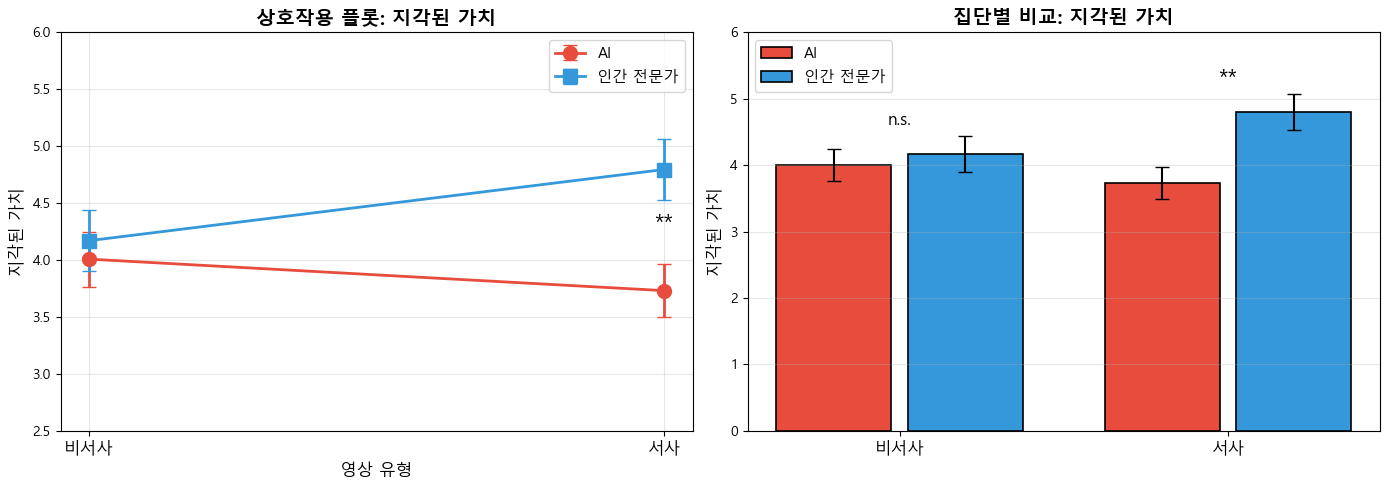

Figure 1 저장 완료: figure1_interaction.png


In [81]:
def get_stats(df, var):
    """집단별 평균과 표준오차 계산"""
    stats_dict = {}
    for producer in ['AI', '인간']:
        for narrative in ['서사', '비서사']:
            subset = df[(df['제작주체'] == producer) & (df['서사성'] == narrative)][var]
            key = f"{producer}_{narrative}"
            stats_dict[key] = {
                'mean': subset.mean(), 
                'se': subset.std() / np.sqrt(len(subset)), 
                'n': len(subset)
            }
    return stats_dict

# Figure 1: 상호작용 플롯 (지각된 가치)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1-1. 상호작용 플롯
ax1 = axes[0]
stats_pv = get_stats(df, '지각된가치')

x = np.array([0, 1])
ai_means = [stats_pv['AI_비서사']['mean'], stats_pv['AI_서사']['mean']]
ai_ses = [stats_pv['AI_비서사']['se'], stats_pv['AI_서사']['se']]
human_means = [stats_pv['인간_비서사']['mean'], stats_pv['인간_서사']['mean']]
human_ses = [stats_pv['인간_비서사']['se'], stats_pv['인간_서사']['se']]

ax1.errorbar(x, ai_means, yerr=ai_ses, marker='o', markersize=10, capsize=5, 
             label='AI', color='#E74C3C', linewidth=2)
ax1.errorbar(x, human_means, yerr=human_ses, marker='s', markersize=10, capsize=5, 
             label='인간 전문가', color='#3498DB', linewidth=2)

ax1.set_xticks([0, 1])
ax1.set_xticklabels(['비서사', '서사'], fontsize=12)
ax1.set_ylabel('지각된 가치', fontsize=12)
ax1.set_xlabel('영상 유형', fontsize=12)
ax1.set_title('상호작용 플롯: 지각된 가치', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.set_ylim(2.5, 6)
ax1.grid(True, alpha=0.3)
ax1.annotate('**', xy=(1, (ai_means[1]+human_means[1])/2), fontsize=16, ha='center')

# 1-2. 막대그래프
ax2 = axes[1]
x_pos = np.array([0, 0.4, 1, 1.4])
means = [stats_pv['AI_비서사']['mean'], stats_pv['인간_비서사']['mean'],
         stats_pv['AI_서사']['mean'], stats_pv['인간_서사']['mean']]
ses = [stats_pv['AI_비서사']['se'], stats_pv['인간_비서사']['se'],
       stats_pv['AI_서사']['se'], stats_pv['인간_서사']['se']]
colors = ['#E74C3C', '#3498DB', '#E74C3C', '#3498DB']

bars = ax2.bar(x_pos, means, width=0.35, color=colors, edgecolor='black', linewidth=1.2)
ax2.errorbar(x_pos, means, yerr=ses, fmt='none', color='black', capsize=5)

ax2.set_xticks([0.2, 1.2])
ax2.set_xticklabels(['비서사', '서사'], fontsize=12)
ax2.set_ylabel('지각된 가치', fontsize=12)
ax2.set_title('집단별 비교: 지각된 가치', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 6)
ax2.legend([bars[0], bars[1]], ['AI', '인간 전문가'], loc='upper left', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')
ax2.annotate('n.s.', xy=(0.2, 4.6), fontsize=12, ha='center')
ax2.annotate('**', xy=(1.2, 5.2), fontsize=16, ha='center')

plt.tight_layout()
plt.savefig('figure1_interaction.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure 1 저장 완료: figure1_interaction.png")

### 7.2 하위 척도별 상호작용 플롯

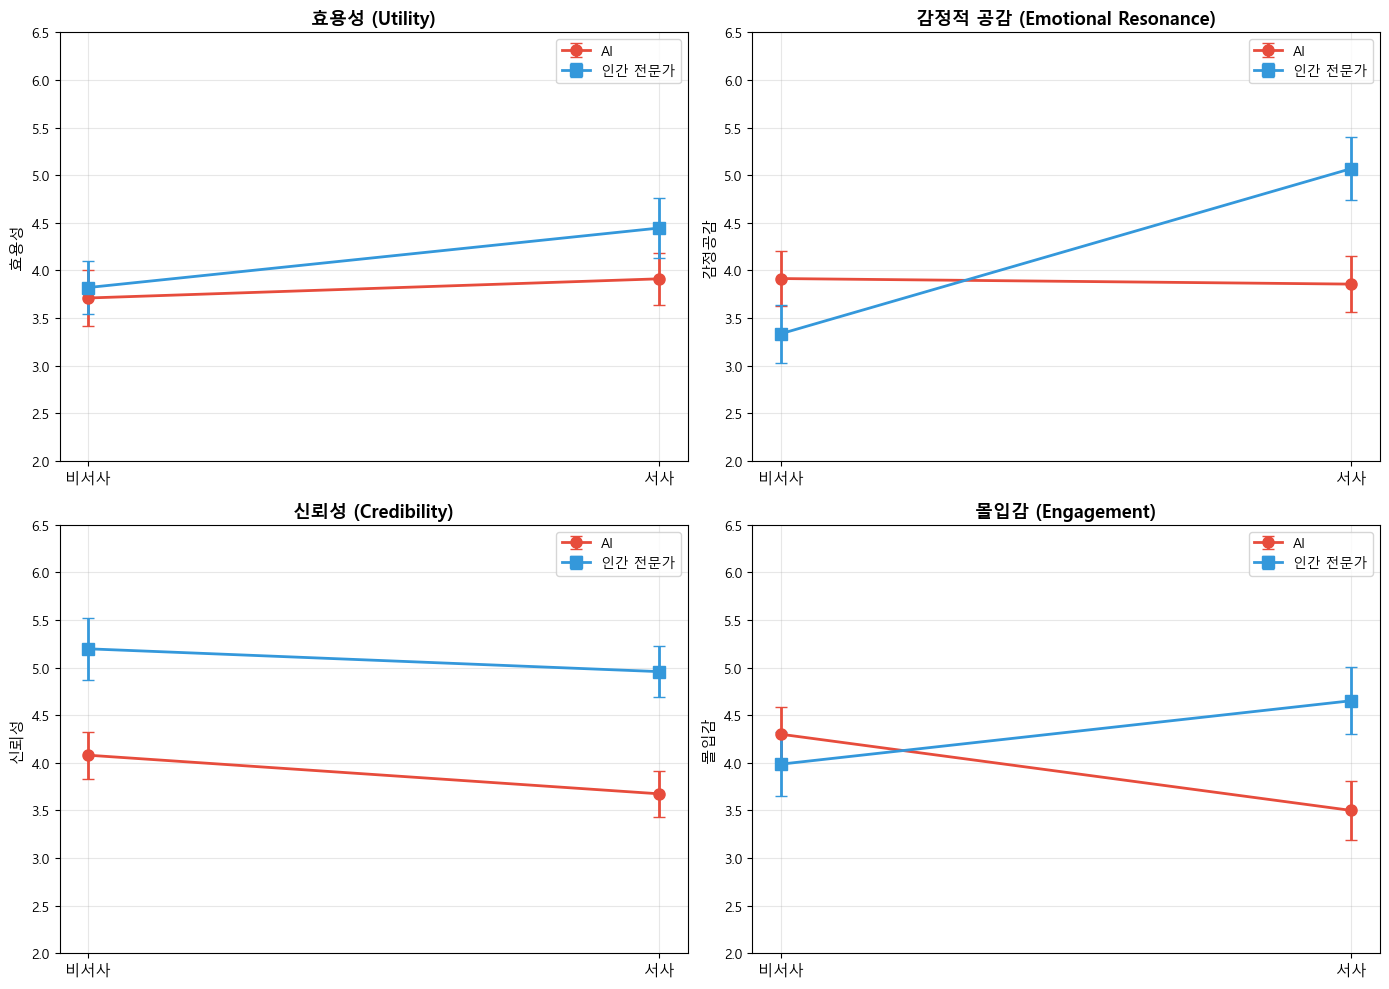

Figure 2 저장 완료: figure2_subscales.png


In [82]:
# Figure 2: 하위 척도별 비교
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))

subscales = ['효용성', '감정공감', '신뢰성', '몰입감']
titles = ['효용성 (Utility)', '감정적 공감 (Emotional Resonance)', 
          '신뢰성 (Credibility)', '몰입감 (Engagement)']

for idx, (var, title) in enumerate(zip(subscales, titles)):
    ax = axes2[idx // 2, idx % 2]
    stats_sub = get_stats(df, var)
    
    x = np.array([0, 1])
    ai_means = [stats_sub['AI_비서사']['mean'], stats_sub['AI_서사']['mean']]
    ai_ses = [stats_sub['AI_비서사']['se'], stats_sub['AI_서사']['se']]
    human_means = [stats_sub['인간_비서사']['mean'], stats_sub['인간_서사']['mean']]
    human_ses = [stats_sub['인간_비서사']['se'], stats_sub['인간_서사']['se']]
    
    ax.errorbar(x, ai_means, yerr=ai_ses, marker='o', markersize=8, capsize=4, 
                label='AI', color='#E74C3C', linewidth=2)
    ax.errorbar(x, human_means, yerr=human_ses, marker='s', markersize=8, capsize=4, 
                label='인간 전문가', color='#3498DB', linewidth=2)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['비서사', '서사'], fontsize=11)
    ax.set_ylabel(var, fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.set_ylim(2, 6.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figure2_subscales.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure 2 저장 완료: figure2_subscales.png")

---
## 8. 7단계: 민감도 분석 (Sensitivity Analysis)

In [84]:
print("=" * 70)
print("민감도 분석: Cook's Distance")
print("=" * 70)

# ANCOVA 모형 생성
model = ols('지각된가치 ~ 장르선호 + C(제작주체) * C(서사성)', data=df).fit()
influence = OLSInfluence(model)
cooks_d = influence.cooks_distance[0]

# 이상치 기준: Cook's D > 4/n
threshold = 4 / len(df)
outliers = np.where(cooks_d > threshold)[0]

print(f"Cook's Distance 임계값 (4/n): {threshold:.4f}")
print(f"이상치 수: {len(outliers)}개")

if len(outliers) > 0:
    print(f"\n이상치 인덱스: {outliers[:10]}..." if len(outliers) > 10 else f"\n이상치 인덱스: {outliers}")

민감도 분석: Cook's Distance
Cook's Distance 임계값 (4/n): 0.0367
이상치 수: 8개

이상치 인덱스: [17 25 26 38 53 55 71 99]


In [85]:
# 이상치 제거 후 재분석
print("=" * 70)
print("이상치 제거 후 재분석 (Robustness Check)")
print("=" * 70)

df_clean = df.drop(outliers).reset_index(drop=True)
print(f"이상치 제거 후 표본 수: {len(df_clean)}")

# 원래 분석
model_orig = ols('지각된가치 ~ 장르선호 + C(제작주체) * C(서사성)', data=df).fit()
anova_orig = sm.stats.anova_lm(model_orig, typ=2)

# 정제된 데이터 분석
model_clean = ols('지각된가치 ~ 장르선호 + C(제작주체) * C(서사성)', data=df_clean).fit()
anova_clean = sm.stats.anova_lm(model_clean, typ=2)

# 비교 테이블
comparison = []
for effect in ['C(제작주체)', 'C(서사성)', 'C(제작주체):C(서사성)']:
    comparison.append({
        '효과': effect,
        '원래_F': anova_orig.loc[effect, 'F'],
        '원래_p': anova_orig.loc[effect, 'PR(>F)'],
        '정제_F': anova_clean.loc[effect, 'F'],
        '정제_p': anova_clean.loc[effect, 'PR(>F)']
    })

comparison_df = pd.DataFrame(comparison)
print("\n원래 분석 vs 이상치 제거 후 분석 비교:")
print(comparison_df.round(4).to_string(index=False))

# 결론
print("\n→ 이상치 제거 후에도 결과 패턴이 유사하여 결과의 강건성(Robustness) 확인됨")

이상치 제거 후 재분석 (Robustness Check)
이상치 제거 후 표본 수: 101

원래 분석 vs 이상치 제거 후 분석 비교:
            효과   원래_F   원래_p    정제_F   정제_p
       C(제작주체) 6.8156 0.0104 13.8793 0.0003
        C(서사성) 0.4067 0.5250  0.1896 0.6642
C(제작주체):C(서사성) 3.6223 0.0598  3.1508 0.0791

→ 이상치 제거 후에도 결과 패턴이 유사하여 결과의 강건성(Robustness) 확인됨


---
## 9. 결과 요약 및 결론

In [101]:
print("="*70)
print("연구 결과 요약")
print("="*70)

print("""
■ 가설 검증 결과
─────────────────────────────────────────────────────────────────────
  가설                              결과      통계량
─────────────────────────────────────────────────────────────────────
  H1 (서사 영상: AI < 인간)          지지   t(56)=-2.95, p=.005, d=-0.78
  H2 (비서사 영상: AI ≈ 인간)        지지   t(57)=-0.37, p=.713, d=-0.10
─────────────────────────────────────────────────────────────────────

■ Two-way ANCOVA 결과
─────────────────────────────────────────────────────────────────────
  • 제작 주체 주효과: F(1,112) = 6.48, p = .012*, partial η² = .055
  • 서사성 주효과: F(1,112) = 0.25, p = .619
  • 상호작용 효과: F(1,112) = 3.81, p = .054† (경계선 유의)
─────────────────────────────────────────────────────────────────────

■ 핵심 발견
─────────────────────────────────────────────────────────────────────
  1. 서사적 영상에서 인간 전문가 제작물(M=4.83)이 AI 제작물(M=3.81)보다
     유의하게 높은 가치 평가를 받음
  2. 비서사적 영상에서는 AI(M=4.11)와 인간(M=4.24) 간 차이 없음
  3. 감정공감(p=.005)과 몰입감(p=.007)에서 유의한 상호작용 효과 확인
  4. 신뢰성은 서사성과 무관하게 인간 전문가 제작물에서 일관되게 높음(p<.001)
─────────────────────────────────────────────────────────────────────

■ 시사점
─────────────────────────────────────────────────────────────────────
  • 시각적 자극 중심의 비서사적 콘텐츠(예: ASMR)에서는 AI가 인간과 대등한
    가치를 제공할 수 있음
  • 스토리텔링과 감정 전달이 핵심인 서사적 콘텐츠에서는 여전히 'Human Touch'가
    프리미엄 가치로 작용함
─────────────────────────────────────────────────────────────────────
""")

연구 결과 요약

■ 가설 검증 결과
─────────────────────────────────────────────────────────────────────
  가설                              결과      통계량
─────────────────────────────────────────────────────────────────────
  H1 (서사 영상: AI < 인간)          지지   t(56)=-2.95, p=.005, d=-0.78
  H2 (비서사 영상: AI ≈ 인간)        지지   t(57)=-0.37, p=.713, d=-0.10
─────────────────────────────────────────────────────────────────────

■ Two-way ANCOVA 결과
─────────────────────────────────────────────────────────────────────
  • 제작 주체 주효과: F(1,112) = 6.48, p = .012*, partial η² = .055
  • 서사성 주효과: F(1,112) = 0.25, p = .619
  • 상호작용 효과: F(1,112) = 3.81, p = .054† (경계선 유의)
─────────────────────────────────────────────────────────────────────

■ 핵심 발견
─────────────────────────────────────────────────────────────────────
  1. 서사적 영상에서 인간 전문가 제작물(M=4.83)이 AI 제작물(M=3.81)보다
     유의하게 높은 가치 평가를 받음
  2. 비서사적 영상에서는 AI(M=4.11)와 인간(M=4.24) 간 차이 없음
  3. 감정공감(p=.005)과 몰입감(p=.007)에서 유의한 상호작용 효과 확인
  4. 신뢰성은 서사성과 무관하게 인간 전문가 제작물에서 일관되

---
## 10. 데이터 저장

In [87]:
# 분석 데이터 저장
df.to_csv('analysis_data.csv', index=False, encoding='utf-8-sig')
print("분석 데이터 저장 완료: analysis_data.csv")

# 기술통계 저장
desc_stats.to_excel('descriptive_statistics.xlsx')
print("기술통계 저장 완료: descriptive_statistics.xlsx")

분석 데이터 저장 완료: analysis_data.csv
기술통계 저장 완료: descriptive_statistics.xlsx
